<a href="https://colab.research.google.com/github/evanheho-bit/homework/blob/main/114011577_%E4%BD%95%E6%98%B6%E7%BF%B0hw4%E6%94%B92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

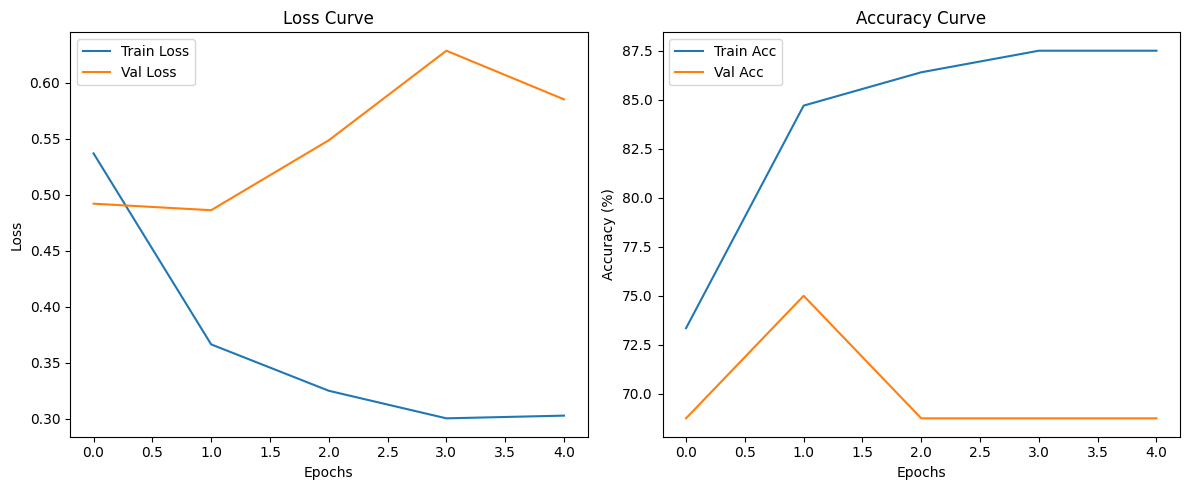

Model weights loaded successfully.
Test Loss: 0.4718, Test Accuracy: 76.12%


(np.float64(0.4717876387712283), np.float64(76.12179487179486))

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ============================================================
# Mount Google Drive & Define Paths
# ============================================================
from google.colab import drive
drive.mount('/content/drive/')

train_path = '/content/drive/MyDrive/colab 03/train'
val_path = '/content/drive/MyDrive/colab 03/val'
test_path = '/content/drive/MyDrive/colab 03/test'

# ============================================================
# Data transforms
# ============================================================
train_transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=3),  # ResNet requires 3 channels
    transforms.ToTensor(),
])

common_transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# ============================================================
# Datasets & Dataloaders
# ============================================================
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ============================================================
# Load Pretrained ResNet18
# ============================================================
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all parameters initially
for param in resnet18.parameters():
    param.requires_grad = False

# Replace the fully connected layer for binary classification
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_ftrs, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

# Unfreeze parameters for the new classifier layer
for param in resnet18.fc.parameters():
    param.requires_grad = True

model = resnet18.to(device)
print(model)

# ============================================================
# Hyperparameters
# ============================================================
lr = 0.0003
weight_decay = 0.01
# Reinitialize optimizer to only optimize unfrozen layers
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')
epochs = 5
criterion = nn.BCELoss()
save = 'model'

# ============================================================
# Train / Validation / Evaluate functions (keep original)
# ============================================================
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.train()
    for batch_idx, (images, labels) in enumerate(train_data_loader):
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels.unsqueeze(1))

        epoch_loss.append(loss.item())
        predicts = (preds > 0.5).float().view(-1).detach().cpu().numpy()
        acc = accuracy_score(labels.detach().cpu().numpy(), predicts)
        epoch_acc.append(acc)

        loss.backward()
        optimizer.step()

    total_time = time.time() - start_time
    return np.mean(epoch_loss), np.mean(epoch_acc)*100, total_time

def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.eval()
    with torch.no_grad():
        for images, labels in val_data_loader:
            images, labels = images.to(device), labels.to(device).float()
            preds = model(images)
            loss = criterion(preds, labels.unsqueeze(1))
            epoch_loss.append(loss.item())
            predicts = (preds > 0.5).float().view(-1).detach().cpu().numpy()
            acc = accuracy_score(labels.detach().cpu().numpy(), predicts)
            epoch_acc.append(acc)

    total_time = time.time() - start_time
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)*100

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"{save}.pth")

    return epoch_loss, epoch_acc, total_time, best_acc

def evaluate(model, device, model_path, test_loader):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model weights loaded successfully.")
    except:
        print("Failed to load model weights, using current weights.")

    model.to(device)
    model.eval()
    test_loss = []
    test_acc = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            preds = model(images)
            loss = criterion(preds, labels.unsqueeze(1))
            test_loss.append(loss.item())
            predicts = (preds > 0.5).float().view(-1).detach().cpu().numpy()
            acc = accuracy_score(labels.detach().cpu().numpy(), predicts)
            test_acc.append(acc)

    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc)*100
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.2f}%")
    return avg_test_loss, avg_test_acc

# ============================================================
# Training Loop
# ============================================================
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_acc = 0.0

for epoch in range(epochs):
    train_loss, train_acc, train_time = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc = val_one_epoch(model, device, criterion, val_loader, best_acc, save)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

    lr_scheduler.step(val_acc)

# ============================================================
# Plotting Loss & Accuracy
# ============================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

# ============================================================
# Test Evaluation
# ============================================================
model_path = f"{save}.pth"
evaluate(model, device, model_path, test_loader)